In [14]:
import matplotlib
%matplotlib nbagg
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
import json
import pandas as pd

from scipy import stats
from scipy.io import loadmat, savemat

#sys.path.append(os.path.expanduser("~/../cs/py2p/tools"))
sys.path.append("../vr")
sys.path.append(os.path.expanduser("../GitHub/py2p/tools"))
os.environ['USER'] = "hello"
sys.path.append(os.path.expanduser("../GitHub/haussmeister"))
sys.path.append(os.path.expanduser("../GitHub/stimfit/src/pystfio"))

import spectral
import move
import imp
imp.reload(move)

import cellspfc
import syncfiles
#from stfio import plot as stfio_plot


import cPickle as pickle
#imp.reload(cellspfc)
from scipy.signal import hilbert
import numpy as np
from haussmeister import spectral as hspectral
from haussmeister import utils as hutils
#import peakutils

rpy2 not available


In [15]:
config = {
    'vsub': -40, # -40
    'vmin': -150, 
    'apthreshold': -30, #-30
    'min_nripples': 3,
    'std_ripple_thresholds': (2, 10),
    'ripple_bandpass': (0.1, 0.2),
    'noise_bandpass': (0.3, 0.5),
    'spindle_bandpass': (0.01, 0.02),
    'resting_threshold': 1.0,
    'running_threshold': 1.0,
    'running_duration': 1000.0,
}

In [16]:
def ripple_stats(ripples, ripple_envelope, speed, config):
    ripples_dict = {
        'ripple_durations_run': [],
        'ripple_amplitudes_run': [],
        'ripple_durations_rest': [],
        'ripple_amplitudes_rest': [],
    }
    run_periods, rest_periods = move.run_rest_periods(
        speed, config['resting_threshold'], config['running_threshold'],
        config['running_duration'])
    for ripple0, ripple1 in zip(ripples[0, :], ripples[1, :]):
        tpeak = np.argmax(
            ripple_envelope.y_trange(ripple0, ripple1))*ripple_envelope.dt + ripple0
        if move.in_period(tpeak, run_periods):
            suffix = 'run'
        else:
            suffix = 'rest'
        ripples_dict['ripple_durations_' + suffix].append(
            ripple1-ripple0)
        ripples_dict['ripple_amplitudes_' + suffix].append(
            np.max(ripple_envelope.y_trange(ripple0, ripple1)))
    run_duration = np.sum([period[1]-period[0] for period in run_periods])
    rest_duration = np.sum([period[1]-period[0] for period in rest_periods])
    print(run_duration, rest_duration)
    if run_duration > 0:
        ripples_dict['ripple_frequency_run'] = len(
            ripples_dict['ripple_durations_run'])/(run_duration*1e-3)
    else:
        ripples_dict['ripple_frequency_run'] = np.nan
    if rest_duration > 0:
        ripples_dict['ripple_frequency_rest'] = len(
            ripples_dict['ripple_durations_rest'])/(rest_duration*1e-3)
    else:
        ripples_dict['ripple_frequency_rest'] = np.nan

    return ripples_dict

In [4]:
def ripple_sta(cell, config):
    V_data, LFP_data, postimes, xpos, ypos, V_clipped_red, V_clipped_red_filt, \
        ap_times, new_speed, speed_pos, speed_filter, yoffset, evlist = \
        syncfiles.assemble_files(cell, False)
    if cell.vm_is_ripple_channel:
        V_data_copy = V_data.data.copy()
        V_data_dt = V_data.dt
        V_data.data = LFP_data.data.copy()
        V_data.dt = LFP_data.dt
        LFP_data.data = V_data_copy
        LFP_data.dt = V_data_dt
    if cell.hum_removal:
        V_data.data, W, f_signal, f_signal_new = hspectral.remove_hum(V_data.data, V_data.dt*1e-3)
        V_clipped_red.data, W, f_signal, f_signal_new = hspectral.remove_hum(V_clipped_red.data, V_clipped_red.dt*1e-3)
    if not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel:
        V_clipped_red_bp = move.mask_spikes2(V_clipped_red, ap_times, pre=20.0, post=20.0)
    else:
        spindle_data_bp = spectral.bandpass(V_data, config['spindle_bandpass'][0], config['spindle_bandpass'][1])
        spindle_envelope_bp = stfio_plot.Timeseries(
            np.abs(hspectral.fhilbert(spindle_data_bp.data)), spindle_data_bp.dt)

    LFP_data_bp = spectral.bandpass(LFP_data, config['ripple_bandpass'][0], config['ripple_bandpass'][1])
    LFP_data = spectral.bandpass(LFP_data, 0.002, 10.0)
    LFP_noise_data_bp = spectral.bandpass(LFP_data, config['noise_bandpass'][0], config['noise_bandpass'][1])
    
    if cell.vm_is_ripple_channel:
        fn_hilbert = os.path.join('dat', cell.unique_name() + '_hilbert_inverted.mat')
    else:
        fn_hilbert = os.path.join('dat', cell.unique_name() + '_hilbert.mat')
    ripples, rippleargmaxs = hspectral.findRipples(
        LFP_data_bp, LFP_noise_data_bp, 
        std_thresholds=config['std_ripple_thresholds'], fn_hilbert=fn_hilbert)
    f_hilbert = loadmat(fn_hilbert)
    ripple_envelope_bp = stfio_plot.Timeseries(np.abs(f_hilbert['signal'][0]), LFP_data_bp.dt)
    LFP_cut = 20.0 # ms
    rippleargmaxs = rippleargmaxs[
                  (ripples[0, :] > int(np.round(LFP_cut/LFP_data_bp.dt))) &
                  (ripples[1, :] < LFP_data_bp.data.shape[0]-int(np.round(LFP_cut/LFP_data_bp.dt)))]
    ripples = ripples[:, 
                  (ripples[0, :] > int(np.round(LFP_cut/LFP_data_bp.dt))) &
                  (ripples[1, :] < LFP_data_bp.data.shape[0]-int(np.round(LFP_cut/LFP_data_bp.dt)))]
    ripple_dict = ripple_stats(
        ripples*LFP_data_bp.dt, ripple_envelope_bp, speed_filter, config)
    print(ripple_dict['ripple_frequency_rest'])
    print(ripple_dict['ripple_frequency_run'])

    pre = 1000.0
    post = 3000.0
    base = 20.0
    peakwindow = 100.0
    mean_v, mean_sub, mean_lfp = [], [], []
    mean_v_bst, mean_sub_bst, mean_lfp_bst = [], [], []
    if cell.vm_is_ripple_channel or cell.vm_is_spindle_channel:
        vsub = spindle_envelope_bp
    else:
        vsub = V_clipped_red_bp
    for ripple, rippleargmax in zip(ripples.T, rippleargmaxs.T):
        lfprippletstart = rippleargmax * LFP_data.dt
        lfps = rippleargmax # ripple[0]
        lfpst = lfps * LFP_data.dt
        
        if not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel:
            if not cell.vclamp:
                V_base = np.mean(V_data.data[
                            int(np.round((lfprippletstart-base)/V_data.dt)):
                            int(np.round((lfprippletstart)/V_data.dt))])
                V_max = np.max(V_data.data[
                            int(np.round((lfprippletstart)/V_data.dt)):
                            int(np.round((lfprippletstart+peakwindow)/V_data.dt))])
                V_half = (V_max-V_base)/2.0 + V_base
                if V_half < 0:
                    ihalf = int(np.round((lfprippletstart)/V_data.dt))
                else:
                    ihalf = np.where(V_data.data[
                            int(np.round((lfprippletstart)/V_data.dt)):
                            int(np.round((lfprippletstart+peakwindow)/V_data.dt))] >= V_half)[0][0] + \
                                int(np.round((lfprippletstart)/V_data.dt))
        
            V_mean = np.mean(V_data.data[
                        int(np.round((lfpst-pre)/V_data.dt)):
                        int(np.round((lfpst+post)/V_data.dt))])
            if  not cell.vclamp and (V_mean >= config['vsub'] or V_mean < config['vmin'] or np.any(
                V_data.data[
                        int(np.round((lfpst-pre)/V_data.dt)):
                        int(np.round((lfpst+post)/V_data.dt))] > config['apthreshold'])):
                continue
        while True:
            lfpsibst = np.random.randint(LFP_data.data.shape[0]-int(np.round((post+pre)/LFP_data.dt))) + int(
                np.round(pre/LFP_data.dt))
            lfpstbst = lfpsibst * LFP_data.dt
            if not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel:
                V_mean_bst = np.mean(V_data.data[
                            int(np.round((lfpstbst-pre)/V_data.dt)):
                            int(np.round((lfpstbst+post)/V_data.dt))])
                if cell.vclamp or (V_mean_bst < config['vsub'] and V_mean_bst >= config['vmin'] and not np.any(
                    V_data.data[
                        int(np.round((lfpstbst-pre)/V_data.dt)):
                        int(np.round((lfpstbst+post)/V_data.dt))] > config['apthreshold'])):
                    break
                else:
                    pass #print(V_mean_bst)
            else:
                break
        for data, mean, mean_bst in zip(
            [V_data, vsub, ripple_envelope_bp],
            [mean_v, mean_sub, mean_lfp],
            [mean_v_bst, mean_sub_bst, mean_lfp_bst]):
            intrange = np.arange(
                -int(np.round(pre/data.dt)),
                int(np.round(post/data.dt)))
            trange = intrange*data.dt
            yrange = data.data[
                    int(np.round((lfpst-pre)/data.dt)):
                    int(np.round((lfpst-pre)/data.dt))+intrange.shape[0]]
            if trange.shape[0] == yrange.shape[0]:
                yrange_bst = data.data[
                        int(np.round((lfpstbst-pre)/data.dt)):
                        int(np.round((lfpstbst-pre)/data.dt))+intrange.shape[0]]
                mean.append((trange[:yrange.shape[0]],
                             yrange[:trange.shape[0]]))
                mean_bst.append((trange[:yrange_bst.shape[0]],
                                 yrange_bst[:trange.shape[0]]))
    if len(mean_sub) > 0:
        mean_sub_y = np.ma.mean(np.ma.array(mean_sub)[:, 1], axis=0)
        mean_ripple_y = np.ma.mean(np.ma.array(mean_lfp)[:, 1], axis=0)
        mean_sub_y_bst = np.ma.mean(np.ma.array(mean_sub_bst)[:, 1], axis=0)
        mean_ripple_y_bst = np.ma.mean(np.ma.array(mean_lfp_bst)[:, 1], axis=0)
        ccorr = hutils.xcorr(mean_sub_y, mean_ripple_y)
        ccorr_bst = hutils.xcorr(mean_sub_y_bst, mean_ripple_y_bst)
    else:
        ccorr = []
        ccorr_bst = []
        
    resultsdict = {
        'mean_v': mean_v,
        'mean_v_bst': mean_v_bst,
        'mean_sub': mean_sub,
        'mean_sub_bst': mean_sub_bst,
        'mean_lfp': mean_lfp,
        'mean_lfp_bst': mean_lfp_bst,
        'xcorr_sub_lfp': ccorr,
        'xcorr_sub_lfp_bst': ccorr_bst,
    }
    resultsdict.update(ripple_dict)
    return resultsdict

In [17]:
cell = cellspfc.ic2018_05_16_c1
V_data, LFP_data, postimes, xpos, ypos, V_clipped_red, V_clipped_red_filt, \
    ap_times, new_speed, speed_pos, speed_filter, yoffset, evlist = \
    syncfiles.assemble_files(cell, False)
if cell.vm_is_ripple_channel:
    sys.stdout.write("Swapping channels...")
    sys.stdout.flush()
    V_data_copy = V_data.data.copy()
    V_data_dt = V_data.dt
    V_data.data = LFP_data.data.copy()
    V_data.dt = LFP_data.dt
    LFP_data.data = V_data_copy
    LFP_data.dt = V_data_dt
    sys.stdout.write(" done\n")
if cell.hum_removal:
    sys.stdout.write("Hum removal...")
    sys.stdout.flush()
    V_data.data, W, f_signal, f_signal_new = hspectral.remove_hum(V_data.data, V_data.dt*1e-3)
    V_clipped_red.data, W, f_signal, f_signal_new = hspectral.remove_hum(V_clipped_red.data, V_clipped_red.dt*1e-3)
    sys.stdout.write(" done\n")
sys.stdout.write("Bandpassing data...")
sys.stdout.flush()
if not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel:
    V_clipped_red_bp = move.mask_spikes2(V_clipped_red, ap_times, pre=20.0, post=20.0)
else:
    spindle_data_bp = spectral.bandpass(V_data, config['spindle_bandpass'][0], config['spindle_bandpass'][1])
    spindle_envelope_bp = stfio_plot.Timeseries(
        np.abs(hspectral.fhilbert(spindle_data_bp.data)), spindle_data_bp.dt)
sys.stdout.write(" done\n")

NameError: name 'cellspfc' is not defined

In [6]:
fn_intan_aux = cell.intan_name(channel='AUX')
fn_intan = cell.intan_name()
print(fn_intan_aux)
import intan
intanf = intan.IntanFile(fn_intan)
intanf_aux = intan.IntanFile(fn_intan_aux)

/home/czhang/Trillian/data/2018/2018-05/2018-05-16/chunlei/ephys__180516_153643/ephys__AUX_180516_153643.clp


In [7]:
intanf_aux.header

{'NumADCs': 8,
 'Settings': {'SamplingRate': 50000.0},
 'datatype': 1,
 'date_Day': 16,
 'date_Hour': 15,
 'date_Minute': 36,
 'date_Month': 5,
 'date_Second': 44,
 'date_Year': 2018,
 'version_major': 1,
 'version_minor': 0}

In [8]:
intanf_aux.data['ADC'].shape
# plt.figure()
# plt.plot(intanf_aux.data['ADC'][8])

(8, 51550000)

In [9]:
LFP_data_bp = spectral.bandpass(LFP_data, config['ripple_bandpass'][0], config['ripple_bandpass'][1])
LFP_data = spectral.bandpass(LFP_data, 0.002, 10.0)
LFP_noise_data_bp = spectral.bandpass(LFP_data, config['noise_bandpass'][0], config['noise_bandpass'][1])

Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (861.49 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (845.53 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (853.08 ms)


In [10]:
if cell.vm_is_ripple_channel:
    fn_hilbert = os.path.join('dat', cell.unique_name() + '_hilbert_inverted.mat')
else:
    fn_hilbert = os.path.join('dat', cell.unique_name() + '_hilbert.mat')
ripples, rippleargmaxs = hspectral.findRipples(
    LFP_data_bp, LFP_noise_data_bp, 
    std_thresholds=config['std_ripple_thresholds'], fn_hilbert=fn_hilbert)
f_hilbert = loadmat(fn_hilbert)
ripple_envelope_bp = stfio_plot.Timeseries(np.abs(f_hilbert['signal'][0]), LFP_data_bp.dt)
LFP_cut = 20.0 # ms
rippleargmaxs = rippleargmaxs[
                  (ripples[0, :] > int(np.round(LFP_cut/LFP_data_bp.dt))) &
                  (ripples[1, :] < LFP_data_bp.data.shape[0]-int(np.round(LFP_cut/LFP_data_bp.dt)))]
ripples = ripples[:, 
                  (ripples[0, :] > int(np.round(LFP_cut/LFP_data_bp.dt))) &
                  (ripples[1, :] < LFP_data_bp.data.shape[0]-int(np.round(LFP_cut/LFP_data_bp.dt)))]
ripple_dict = ripple_stats(
    ripples*LFP_data_bp.dt, ripple_envelope_bp, speed_filter, config)
print(ripple_dict['ripple_frequency_rest'])
print(ripple_dict['ripple_frequency_run'])

(12305, 28910)
0.8993427879626427
0.0


<IPython.core.display.Javascript object>


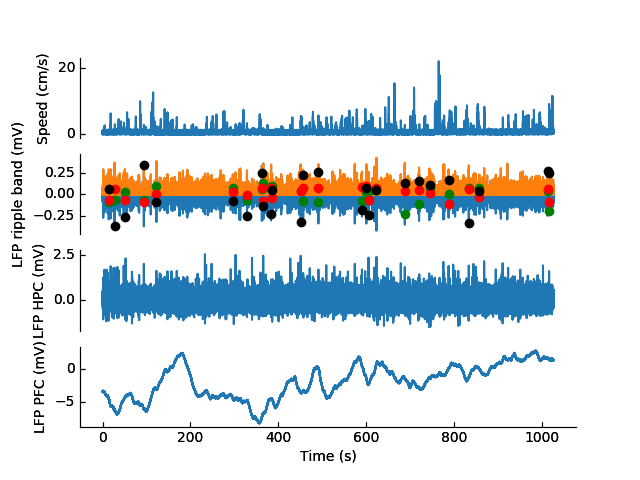

In [11]:
fig = plt.figure()
ax1 = stfio_plot.StandardAxis(fig, 411, hasx=False)
ax1.plot(speed_filter.timearray()*1e-3, speed_filter.data)
ax1.set_ylabel('Speed (cm/s)')
ax2 = stfio_plot.StandardAxis(fig, 412, hasx=False, sharex=ax1)
ax2.plot(LFP_data_bp.timearray()*1e-3, LFP_data_bp.data)
ax2.plot(ripple_envelope_bp.timearray()*1e-3, ripple_envelope_bp.data)
if len(rippleargmaxs) > 0:
    ax2.plot(LFP_data_bp.timearray()[ripples[0, :]]*1e-3, LFP_data_bp.data[ripples[0, :]], 'og')
    ax2.plot(LFP_data_bp.timearray()[ripples[1, :]]*1e-3, LFP_data_bp.data[ripples[1, :]], 'or')
    ax2.plot(LFP_data_bp.timearray()[rippleargmaxs]*1e-3, LFP_data_bp.data[rippleargmaxs], 'ok')
ax2.set_ylabel('LFP ripple band (mV)')
ax3 = stfio_plot.StandardAxis(fig, 413, hasx=False, sharex=ax1)
ax3.plot(LFP_data.timearray()*1e-3, LFP_data.data)
ax3.set_ylabel('LFP HPC (mV)')
ax4 = stfio_plot.StandardAxis(fig, 414, hasx=True, sharex=ax1)
ax4.plot(V_data.timearray()*1e-3, V_data.data)
if not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel and not cell.vclamp:
    ax4.set_ylabel(r'Vm PFC (mV)')
elif not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel and cell.vclamp:
    ax4.set_ylabel(r'I PFC (pA)')
else:
    ax4.set_ylabel(r'LFP PFC (mV)')
ax4.set_xlabel('Time (s)')
    
# ax4.set_xlim(190.26, 190.43)
# ax4.set_ylim(-107, -98)
plt.savefig(os.path.join('fig', cell.unique_name() + '_ripple_example.pdf'))

# THIS CODE PLOTS ALL RIPPLE-ALIGNED TRACES FOR AN INDIVIDUAL RECORDING

In [ ]:
fig = plt.figure(figsize=(8, 12))
ax1 = stfio_plot.StandardAxis(fig, 311, hasx=False)
ax2 = stfio_plot.StandardAxis(fig, 312, hasx=False, sharex=ax1)
ax3 = stfio_plot.StandardAxis(fig, 313, hasx=True, sharex=ax1)
pre = 200.0
post = 1000.0
mean_v, mean_sub, mean_lfp = [], [], []
if cell.vm_is_ripple_channel or cell.vm_is_spindle_channel:
    vsub = spindle_envelope_bp
else:
    vsub = V_clipped_red_bp
for ripple, rippleargmax in zip(ripples.T, rippleargmaxs.T):
    lfps = rippleargmax # ripple[0]
    for ax, data, mean in zip(
        [ax1, ax2, ax3],
        [V_data, vsub, ripple_envelope_bp],
        [mean_v, mean_sub, mean_lfp]):
        lfpst = lfps * LFP_data.dt
        intrange = np.arange(
            -int(np.round(pre/data.dt)),
            int(np.round(post/data.dt)))
        trange = intrange*data.dt
        yrange = data.data[
                int(np.round((lfpst-pre)/data.dt)):
                int(np.round((lfpst-pre)/data.dt))+intrange.shape[0]]
        if trange.shape[0] == yrange.shape[0]:
            ax.plot(
                trange[:yrange.shape[0]],
                yrange[:trange.shape[0]], '-b', alpha=0.4, 
            )
            mean.append((trange[:yrange.shape[0]],
                         yrange[:trange.shape[0]]))
mean_sub_y = np.ma.mean(np.ma.array(mean_sub)[:, 1], axis=0)
mean_ripple_y = np.ma.mean(np.ma.array(mean_lfp)[:, 1], axis=0)
ax2.plot(
    np.ma.mean(np.ma.array(mean_sub)[:, 0], axis=0),
    mean_sub_y,
    '-r', lw=3
)
ax3.plot(
    np.ma.mean(np.ma.array(mean_lfp)[:, 0], axis=0),
    mean_ripple_y,
    '-r', lw=3
)
crossc = hutils.xcorr(mean_sub_y, mean_ripple_y)

if not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel and not cell.vclamp:
    ax1.set_ylabel(r'V_m PFC (mV)')
    ax2.set_ylabel(r'DV_m PFC (mV)')
elif not cell.vm_is_ripple_channel and not cell.vm_is_spindle_channel and cell.vclamp:
    ax1.set_ylabel(r'I PFC (pA)')
    ax2.set_ylabel(r'DI PFC (pA)')
else:
    ax1.set_ylabel(r'LFP PFC (mV)')
    ax2.set_ylabel(r'LFP spindle band amp PFC (mV)')
ax3.set_ylabel(r'LFP ripple band amp HPC (mV)')
ax3.set_xlabel('Time (ms)')

fig.savefig(os.path.join("fig", cell.unique_name() + "lfp_aligned.pdf"))

fig = plt.figure()
plt.plot(np.arange(crossc.shape[0])*vsub.dt-crossc.shape[0]/2*vsub.dt, crossc)


# Summary

In [23]:
cell_mean, cell_mean_bst = [], []##
resultsfn = os.path.join(
    '/media', 'DriveStation', 'data', 'analysis', 'ripples.pck')

# if os.path.exists(resultsfn):
#     with open(resultsfn, 'rb') as resultsf:
#         results = pickle.load(resultsf)
# else:
sys.stderr.write(resultsfn + " does not exist")
results = {}

passive_cells = cellspfc.cells_dHPC_SWR_passive_deep + cellspfc.cells_dHPC_SWR_passive_superficial
notrain_cells = cellspfc.cells_dHPC_SWR_notrain_superficial + cellspfc.cells_dHPC_SWR_notrain_deep
train_cells = cellspfc.cells_dHPC_SWR_train_superficial + cellspfc.cells_dHPC_SWR_train_deep
habituate_cells = cellspfc.cells_dHPC_SWR_habituate_superficial + cellspfc.cells_dHPC_SWR_habituate_deep
#halftrain_cells = cellspfc.cells_dHPC_SWR_halftrain_superficial + cellspfc.cells_dHPC_SWR_halftrain_deep
all_cells = passive_cells + notrain_cells + train_cells + habituate_cells #+ halftrain_cells

/media/DriveStation/data/analysis/ripples.pck does not exist

In [24]:
newresults = False
def norm(data):
    ret = data-data.min()
    return ret/ret.max()

for cell in cellspfc.cells_dHPC_SWR_VC_notrain_deep:# all_cells: # cellspfc.cells_dHPC_SWR_notrain_PFCfield:# train_cells: # + cellspfc.cells_dHPC_SWR_reward_superficial + cellspfc.cells_dHPC_SWR_reward_deep:
    print(cell.unique_name())
    keydict = dict({'cellname': cell.unique_name()}, **config)
    hashkey = json.dumps(keydict, sort_keys=True)
    if True: # not hashkey in results.keys():
        results[hashkey] = ripple_sta(cell, config)
        newresults = True

    mean_sub = results[hashkey]['mean_sub']
    mean_sub_bst = results[hashkey]['mean_sub_bst']
    
    if len(mean_sub) >= config['min_nripples']:
        cell_mean.append([
            np.ma.mean(np.ma.array(mean_sub)[:, 0], axis=0),
            np.ma.mean(np.ma.array(mean_sub)[:, 1], axis=0)-np.ma.mean(np.ma.array(mean_sub)[:, 1]),
        ])
        cell_mean_bst.append([
            np.ma.mean(np.ma.array(mean_sub_bst)[:, 0], axis=0),
            np.ma.mean(np.ma.array(mean_sub_bst)[:, 1], axis=0)-np.ma.mean(np.ma.array(mean_sub_bst)[:, 1]),
        ])
    else:
        print("Not enough ripples")

if newresults:
    with open(resultsfn, 'wb') as resultsf:
        pickle.dump(results, resultsf)

cell_mean = np.array(cell_mean)
cell_mean_bst = np.array(cell_mean_bst)

20180622_ic2018_06_22_c1
Reading pre-assembled files for 20180622_ic2018_06_22_c1... done
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (31.47 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (279.36 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (270.07 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (267.11 ms)
(55778, 0.0)
nan
0.0
Not enough ripples
20180702_ic2018_07_02_c1
Reading pre-assembled files for 20180702_ic2018_07_02_c1... done
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (14.75 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (67.97 ms)
Computing frequencies... done
Forward fft (convolve)... done
Reverse fft (convolve)... done (69.13 ms)
Computing frequencies... done
Forward fft (convolve)... 

<IPython.core.display.Javascript object>


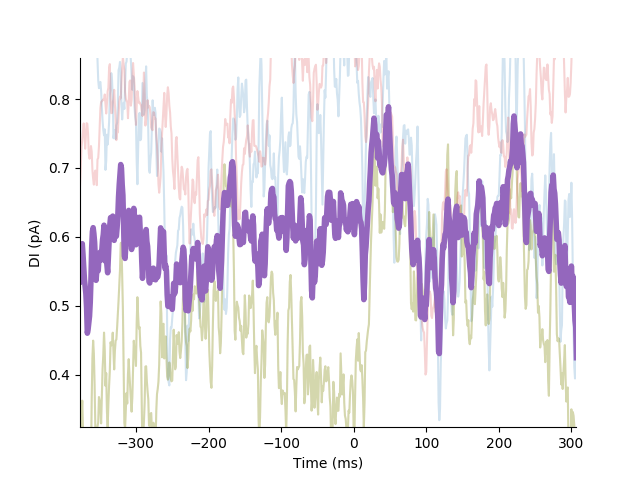

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
for tmean, vmean in zip(cell_mean[:, 0], cell_mean[:, 1]):
    ax.plot(tmean, vmean, alpha=0.2)
 # ax.plot(tmean, np.ma.mean(cell_mean_bst[:, 1], axis=0)+2.0*np.ma.std(cell_mean_bst[:, 1], axis=0), '-r', lw=2)
 # ax.plot(tmean, np.ma.mean(cell_mean_bst[:, 1], axis=0)-2.0*np.ma.std(cell_mean_bst[:, 1], axis=0), '-r', lw=2)
ax.plot(tmean, np.ma.mean(cell_mean[:, 1], axis=0), lw=4)

ax.set_xlim(-1000, 2000)
if not cell.vclamp:
    ax.set_ylabel(r'DVm (mV)')
else:
    ax.set_ylabel(r'DI (pA)')
    
ax.set_xlabel('Time (ms)')
sns.despine()
# plt.savefig(os.path.join('fig', 'ripples_spindles_notrain_{0}mV_to_{1}mV.pdf'.format(config['vmin'], config['vsub'])))

# Comparison

In [ ]:
resultsfn = os.path.join(
    '/media', 'DriveStation', 'data', 'analysis', 'ripples.pck')
with open(resultsfn, 'rb') as resultsf:
    results = pickle.load(resultsf)

In [ ]:
results_table = []
tbasestart = -75 # -100
tbaseend = -25
tpeakstart = tbaseend
tpeakend = 25

for cell in all_cells:
    keydict = dict({'cellname': cell.unique_name()}, **config)
    hashkey = json.dumps(keydict, sort_keys=True)
    if not hashkey in results.keys():
        raise RuntimeError("Analysis for cell " + cell.unique_name() + " is missing. Run analysis first.")

    if cell in cellspfc.cells_dHPC_SWR_train_deep + \
        cellspfc.cells_dHPC_SWR_notrain_deep + \
        cellspfc.cells_dHPC_SWR_habituate_deep + \
        cellspfc.cells_dHPC_SWR_passive_deep:
        layer = 'deep'
    else:
        layer = 'superficial'

    if cell in cellspfc.cells_dHPC_SWR_train_superficial + cellspfc.cells_dHPC_SWR_train_deep:
        train = 'trained'
    elif cell in cellspfc.cells_dHPC_SWR_notrain_superficial + cellspfc.cells_dHPC_SWR_notrain_deep:
        train = 'untrained'
    elif cell in cellspfc.cells_dHPC_SWR_habituate_superficial + cellspfc.cells_dHPC_SWR_habituate_deep:
        train = 'habituation'
    else:
        train = 'passive'

    mean_sub = results[hashkey]['mean_sub']
    if len(mean_sub) >= config['min_nripples']:
        mean_time = np.ma.mean(np.ma.array(mean_sub)[:, 0], axis=0)
        mean_trace = np.ma.mean(np.ma.array(mean_sub)[:, 1], axis=0)-np.ma.mean(np.ma.array(mean_sub)[:, 1])
        trange = mean_time
        vbase = np.ma.mean(mean_trace[(trange >= tbasestart) & (trange < tbaseend)])
        vmax = np.ma.mean(mean_trace[(trange >= tpeakstart) & (trange < tpeakend)])
        amp = vmax - vbase
    else:
        amp = np.nan
    if train == 'trained':
        print(cell.unique_name(), amp)
    results_table.append({
        'cell_name': cell.unique_name(),
        'layer': layer,
        'train': train, 
        'amp': amp
    })

results_table = pd.DataFrame(results_table)
results_table.to_pickle(os.path.join('dat', 'ripples_table.pck'))

In [ ]:
results_table.to_excel(os.path.join('dat', 'ripples_table.xls'))

In [ ]:
def barplot(ax, subresults, column):
    all_data  = []
    for res in subresults[column]:
        if not np.isnan(res):
            ax.plot(0, res, 'ok', alpha=0.5, ms=8, mec='none')
            all_data.append(res)

    ax.errorbar(0, np.ma.mean(all_data), yerr=stats.sem(all_data))
    ax.bar(0, np.ma.mean(all_data), alpha=0.5)

fig = plt.figure(figsize=(16, 12))
axref, axs = [], []
axoff = 1
column = 'amp'

axref.append(fig.add_subplot(1, 11, axoff))
barplot(axref[-1], results_table[
    (results_table.layer == 'superficial')], column)
axref[-1].set_title('Superficial layers')
    
axs.append(fig.add_subplot(1, 11, axoff+1, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'deep')], column)
axs[-1].set_title('Deep layers')

axs.append(fig.add_subplot(1, 11, axoff+2, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.train == 'untrained')], column)
axs[-1].set_title('Untrained')

axs.append(fig.add_subplot(1, 11, axoff+3, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.train == 'passive')], column)
axs[-1].set_title('Passive')

axs.append(fig.add_subplot(1, 11, axoff+4, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.train == 'trained')], column)
axs[-1].set_title('Trained')

axs.append(fig.add_subplot(1, 11, axoff+5, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'superficial') & (results_table.train == 'untrained')], column)
axs[-1].set_title('Surf\Untrained')
    
axs.append(fig.add_subplot(1, 11, axoff+6, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'deep') & (results_table.train == 'untrained')], column)
axs[-1].set_title('Deep\Untrained')

axs.append(fig.add_subplot(1, 11, axoff+7, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'superficial') & (results_table.train == 'passive')], column)
axs[-1].set_title('Surf\Passive')
    
axs.append(fig.add_subplot(1, 11, axoff+8, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'deep') & (results_table.train == 'passive')], column)
axs[-1].set_title('Deep\Passive')

axs.append(fig.add_subplot(1, 11, axoff+9, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'superficial') & (results_table.train == 'trained')], column)
axs[-1].set_title('Surf\Trained')
    
axs.append(fig.add_subplot(1, 11, axoff+10, sharey=axref[-1]))
barplot(axs[-1], results_table[
    (results_table.layer == 'deep') & (results_table.train == 'trained')], column)
axs[-1].set_title('Deep\Trained')

sns.despine(ax=axref[-1], bottom=True)
axref[-1].xaxis.set_visible(False)
for ax in axs:
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    sns.despine(ax=ax, left=True, bottom=True)
axref[0].set_ylabel('Delta Vm (mV)')
plt.savefig(os.path.join('fig', 'ripple_DVm_comparison.pdf'))

## Stats

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.train == 'trained')]['amp'],
    results_table[
        (results_table.train == 'passive')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.train == 'trained')]['amp'],
    results_table[
        (results_table.train == 'untrained')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.train == 'passive')]['amp'],
    results_table[
        (results_table.train == 'untrained')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.layer == 'deep') & (results_table.train == 'trained')]['amp'],
    results_table[
        (results_table.layer == 'deep') & (results_table.train == 'passive')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.layer == 'deep') & (results_table.train == 'trained')]['amp'],
    results_table[
        (results_table.layer == 'deep') & (results_table.train == 'untrained')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.layer == 'deep') & (results_table.train == 'passive')]['amp'],
    results_table[
        (results_table.layer == 'deep') & (results_table.train == 'untrained')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.layer == 'superficial') & (results_table.train == 'trained')]['amp'],
    results_table[
        (results_table.layer == 'superficial') & (results_table.train == 'passive')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.layer == 'superficial') & (results_table.train == 'trained')]['amp'],
    results_table[
        (results_table.layer == 'superficial') & (results_table.train == 'untrained')]['amp'])
print(U, p)

In [ ]:
U, p = stats.mannwhitneyu(
    results_table[
        (results_table.layer == 'superficial')]['amp'],
    results_table[
        (results_table.layer == 'deep')]['amp'])
print(U, p)

# Ripple analysis

In [ ]:
resultsfn = os.path.join(
    '/media', 'DriveStation', 'data', 'analysis', 'ripples.pck')
with open(resultsfn, 'rb') as resultsf:
    results = pickle.load(resultsf)

In [ ]:
ripple_stats_table = []


for cell in all_cells:
    keydict = dict({'cellname': cell.unique_name()}, **config)
    hashkey = json.dumps(keydict, sort_keys=True)
    if not hashkey in results.keys():
        raise RuntimeError("Analysis for cell " + cell.unique_name() + " is missing. Run analysis first.")

    if cell in cellspfc.cells_dHPC_SWR_train_deep + \
        cellspfc.cells_dHPC_SWR_notrain_deep + \
        cellspfc.cells_dHPC_SWR_passive_deep:
        layer = 'deep'
    else:
        layer = 'superficial'

    if cell in cellspfc.cells_dHPC_SWR_train_superficial + cellspfc.cells_dHPC_SWR_train_deep:
        train = 'trained'
    elif cell in cellspfc.cells_dHPC_SWR_notrain_superficial + cellspfc.cells_dHPC_SWR_notrain_deep:
        train = 'untrained'
    else:
        train = 'passive'
    ripple_stats_table.append({
        'cell_name': cell.unique_name(),
        'layer': layer,
        'train': train,
        'ripple_duration_run': np.ma.mean(results[hashkey]['ripple_durations_run']),
        'ripple_duration_rest': np.ma.mean(results[hashkey]['ripple_durations_rest']),
        'ripple_amplitude_run': np.ma.mean(results[hashkey]['ripple_amplitudes_run']),
        'ripple_amplitude_rest': np.ma.mean(results[hashkey]['ripple_amplitudes_rest']),
        'ripple_frequency_run': results[hashkey]['ripple_frequency_run'],
        'ripple_frequency_rest': results[hashkey]['ripple_frequency_rest'],
    })

ripple_stats_table = pd.DataFrame(ripple_stats_table)
ripple_stats_table.to_pickle(os.path.join('dat', 'ripples_stats_table.pck'))

In [ ]:
ripple_stats_table.to_excel(os.path.join('dat', 'ripples_stats_table.xls'))

In [ ]:
def barplot(ax, subresults, column):
    all_data  = []
    for res in subresults[column]:
        if not np.isnan(res):
            ax.plot(0, res, 'ok', alpha=0.5, ms=8, mec='none')
            all_data.append(res)

    ax.errorbar(0, np.ma.mean(all_data), yerr=stats.sem(all_data))
    ax.bar(0, np.ma.mean(all_data), alpha=0.5)

fig = plt.figure(figsize=(4, 6))
axref, axs = [], []
axoff = 1
column = 'ripple_frequency_rest'

axref.append(fig.add_subplot(1, 2, axoff))
barplot(axref[-1], ripple_stats_table[
    (ripple_stats_table.train == 'trained')], column)
axref[-1].set_title('Trained')
    
axs.append(fig.add_subplot(1, 2, axoff+1, sharey=axref[-1]))
barplot(axs[-1], ripple_stats_table[
    (ripple_stats_table.train == 'untrained')], column)
axs[-1].set_title('Untrained')


sns.despine(ax=axref[-1], bottom=True)
axref[-1].xaxis.set_visible(False)
for ax in axs:
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    sns.despine(ax=ax, left=True, bottom=True)
axref[0].set_ylabel('Ripple frequency, resting')


fig = plt.figure(figsize=(4, 6))
axref, axs = [], []
axoff = 1
column = 'ripple_amplitude_rest'

axref.append(fig.add_subplot(1, 2, axoff))
barplot(axref[-1], ripple_stats_table[
    (ripple_stats_table.train == 'trained')], column)
axref[-1].set_title('Trained')
    
axs.append(fig.add_subplot(1, 2, axoff+1, sharey=axref[-1]))
barplot(axs[-1], ripple_stats_table[
    (ripple_stats_table.train == 'untrained')], column)
axs[-1].set_title('Untrained')


sns.despine(ax=axref[-1], bottom=True)
axref[-1].xaxis.set_visible(False)
for ax in axs:
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    sns.despine(ax=ax, left=True, bottom=True)
axref[0].set_ylabel('Ripple amplitude, resting')

fig = plt.figure(figsize=(4, 6))
axref, axs = [], []
axoff = 1
column = 'ripple_duration_rest'

axref.append(fig.add_subplot(1, 2, axoff))
barplot(axref[-1], ripple_stats_table[
    (ripple_stats_table.train == 'trained')], column)
axref[-1].set_title('Trained')
    
axs.append(fig.add_subplot(1, 2, axoff+1, sharey=axref[-1]))
barplot(axs[-1], ripple_stats_table[
    (ripple_stats_table.train == 'untrained')], column)
axs[-1].set_title('Untrained')


sns.despine(ax=axref[-1], bottom=True)
axref[-1].xaxis.set_visible(False)
for ax in axs:
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    sns.despine(ax=ax, left=True, bottom=True)
axref[0].set_ylabel('Ripple duration, resting')